In [360]:
import pandas as pd
from pyvis.network import Network
import networkx as nx
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
from statistics import mean
import scipy.stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

In [177]:
import warnings
warnings.filterwarnings("ignore")

In [179]:
#Load the Twitter API extracted files for each Network

import json

with open('Retweet-JSON/#Bitcoin.json','r') as f:
    bitcoin = json.load(f)

with open('Retweet-JSON/#BoredApeYachtClub.json','r') as f:
    boredApeYachtClub = json.load(f)

with open('Retweet-JSON/#chatgpt.json','r') as f:
    chatGPT = json.load(f)

with open('Retweet-JSON/#energy.json','r') as f:
    energy = json.load(f)

with open('Retweet-JSON/#Eth.json','r') as f:
    eth = json.load(f)

with open('Retweet-JSON/#uranium.json','r') as f:
    uranium = json.load(f)

In [180]:
def tweetcount(hashtag):
    """
    input: the JSON file for the Network
    output: calculates the number of tweets per node in the network
    """
    tweetcount = {}
    for tweeta in hashtag:
        if 'retweeted_status' in tweeta:
            screen_name = tweeta['retweeted_status']['user']['screen_name']
            tweet_text = tweeta['full_text']
            
            # Check if the screen name exists as a key and if the tweet is already in their list
            if screen_name in tweetcount:
                if tweet_text not in tweetcount[screen_name]:
                    tweetcount[screen_name].append(tweet_text)
            else:
                # Initialize with the first tweet's text if the key doesn't exist
                tweetcount[screen_name] = [tweet_text]
    return tweetcount

In [181]:
def retweetcount(hashtag):
    """
    input: the JSON file for the Network
    output: calculates the number of re-tweets per node in the network
    """
    
    retweetcount = {}

    for tweets in hashtag:
        if 'retweeted_status' in tweets:
            screen_name = tweets['user']['screen_name']
            tweet_text = tweets['full_text']
            
            # Check if the screen name exists as a key and if the tweet is already in their list
            if screen_name in retweetcount:
                if tweet_text not in retweetcount[screen_name]:
                    retweetcount[screen_name].append(tweet_text)
            else:
                # Initialize with the first tweet's text if the key doesn't exist
                retweetcount[screen_name] = [tweet_text]
    return retweetcount

In [395]:
def Networkplt(hashtag):
    """
    input: the JSON file for the Network
    output: a pyvis object and a Networkx object for the input Network
    """

    G = nx.DiGraph()
    tc = tweetcount(hashtag)               # A dictionary with original tweeter's tweets
    rtc = retweetcount(hashtag)            # A dictionary with retweeter's tweets 
    for tweet in hashtag:
        retweeter_name = tweet['user']['screen_name']
        retweeter_follower_c = tweet['user']['followers_count']
        if 'retweeted_status' in tweet:
            original_tweeter_name = tweet['retweeted_status']['user']['screen_name']
            orignal_tweeter_follower_c = tweet['retweeted_status']['user']['followers_count']
            if G.has_edge(original_tweeter_name,retweeter_name):
                G.edges[original_tweeter_name,retweeter_name]['weight']+=1
    
            else:
                G.add_node(retweeter_name,weight = retweeter_follower_c, value =int(math.log(len(rtc[retweeter_name]))), color = 'blue')
                G.add_node(original_tweeter_name, weight = orignal_tweeter_follower_c, value = int(math.log(len(tc[original_tweeter_name]))), color ='Red')
                G.add_edge(original_tweeter_name,retweeter_name, weight = 1)
        
    G.remove_edges_from(nx.selfloop_edges(G))
    #G = nx.k_core(G,2)
    nt = Network(directed=nx.is_directed(G), notebook=True,height='800px', width='100%')
    nt.from_nx(G)
    #nt.show_buttons(filter_=['physics'])
    nt.toggle_physics(False) # to avoid initial slow rendering
    # to activate forceAtlas2Based and interaction options
    nt.show_buttons(filter_=['physics', 'interaction'])
    return nt,G
    
    

In [396]:
nt, GPT = Networkplt(chatGPT)  #the Networkx object and pyvis object for plotting the network
#nt.show('GPT.html')

In [333]:
nt, BTC = Networkplt(bitcoin)
#nt.show('BTC.html')

In [337]:
nt, BRD = Networkplt(boredApeYachtClub)
#nt.show('boredApeYachtclub.html')

In [339]:
nt, ENG = Networkplt(energy)
#nt.show('energy.html')

In [397]:
nt, ETH = Networkplt(eth)
#nt.show('eth.html')

In [237]:
nt, URA = Networkplt(uranium)
#nt.show('uranium.html')

In [196]:
def NodeStats (G, Gjson):
    """
    Input: the Networkx object and JSON row file of the Network
    Output: Dataframe with statistics calculated per Node.
    """
    in_degree = pd.DataFrame.from_dict(dict(G.in_degree()),orient ='index',columns=['in_degree']).sort_index()
    out_degree = pd.DataFrame.from_dict(dict(G.out_degree()), orient = 'index', columns = ['out_degree']).sort_index()
    degree = pd.DataFrame.from_dict(dict(G.degree()), orient = 'index', columns = ['degree']).sort_index()
    closeness = pd.DataFrame.from_dict(dict(nx.closeness_centrality(G,wf_improved=True)), orient = 'index', columns = ['closeness']).sort_index()
    betweeness = pd.DataFrame.from_dict(dict(nx.betweenness_centrality(G, normalized=True)), orient = 'index', columns = ['betweeness']).sort_index()
    #assortitivity = pd.DataFrame.from_dict(dict(nx.attribute_assortativity_coefficient(G)), orient = 'index', columns = ['betweeness']).sort_index()
    #nfollowers = pd.DataFrame.from_dict(dict(GPT.nodes)}), orient = 'index', columns = ['betweeness'])
    ntweets = pd.DataFrame.from_dict({node: len(att) for node,att in dict(tweetcount(Gjson)).items()},orient='index', columns = ['ntweets']).sort_index()
    nretweets = pd.DataFrame.from_dict({node: len(att) for node,att in dict(retweetcount(Gjson)).items()},orient='index', columns = ['nretweets']).sort_index()
    nfollowers = pd.DataFrame.from_dict({node: att['weight'] for node,att in G.nodes(data=True)},orient='index', columns = ['nfollowers']).sort_index()
    tweet_type = pd.DataFrame.from_dict({node: att['color'] for node,att in G.nodes(data=True)},orient='index', columns = ['tweet_type']).sort_index()
    tweet_type.replace(['Red','Blue'], ['Tweeter','retweeter'],inplace=True)
    
    NodeStats = pd.concat([in_degree,out_degree,degree,closeness,betweeness,ntweets,nretweets,nfollowers,tweet_type],axis=1)
    
    NodeStats['virality'] = NodeStats['out_degree']/NodeStats['nfollowers'] # Calculating virality as higher the out degree with less no. of follower 
    
    bins = [0,5,10,20,50,100,150,200,300,1000]               #Adding degree bins
    labels = ['5', '10','20', '50','100','150','200','300','1000']
    NodeStats['degree_category'] = pd.cut(NodeStats['degree'], bins=bins, labels=labels, right=False)
    
    NodeStats = NodeStats.sort_values(by='out_degree',ascending=False)
    return NodeStats

In [197]:
#Node statistics per Network
BTC_Stat = NodeStats(BTC,bitcoin)
GPT_Stat = NodeStats(GPT,chatGPT)
BRD_Stat = NodeStats(BRD,boredApeYachtClub)
ENG_Stat = NodeStats(ENG,energy)
ETH_Stat = NodeStats(ETH,eth)
URA_Stat = NodeStats(URA,uranium)

In [23]:
BTC_Stat['Hashtag']='#Bitcoin'
GPT_Stat['Hashtag']='#chatGPT'
BRD_Stat['Hashtag']='#BoredApeYatch'
ENG_Stat['Hashtag']='#energy'
ETH_Stat['Hashtag']='#Eth'
URA_Stat['Hashtag']='#uranium'
Stats_comb = pd.concat([BTC_Stat,GPT_Stat,BRD_Stat,ENG_Stat,ETH_Stat,URA_Stat], axis=0)

In [24]:
Stats_comb.reset_index(inplace=True,names=['Node'])

In [211]:
br = Stats_comb[Stats_comb['Hashtag']=='#BoredApeYatch']

In [213]:
br.to_csv("BRD.csv")

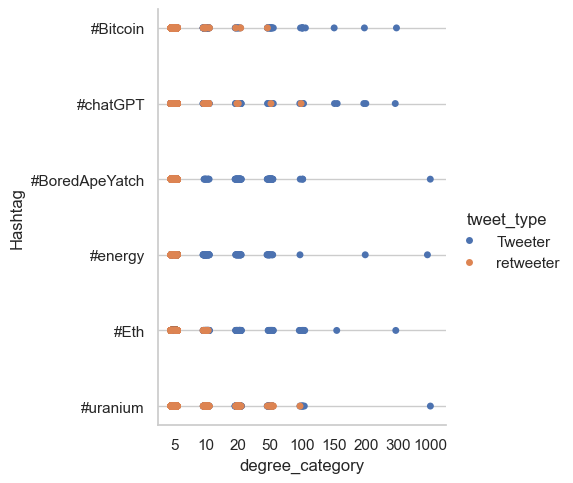

In [243]:
ax1= sns.catplot(x='degree_category', y='Hashtag', hue='tweet_type',
                kind='strip', data=Stats_comb)

In [244]:
TweetAgg = Stats_comb.groupby('Hashtag').agg({'ntweets':sum,'nretweets':sum}).reset_index() #Calculating the tweets sum per network

In [245]:
TweetAgg = TweetAgg.melt(id_vars=['Hashtag'],var_name='TweetType', value_name='TweetCount')

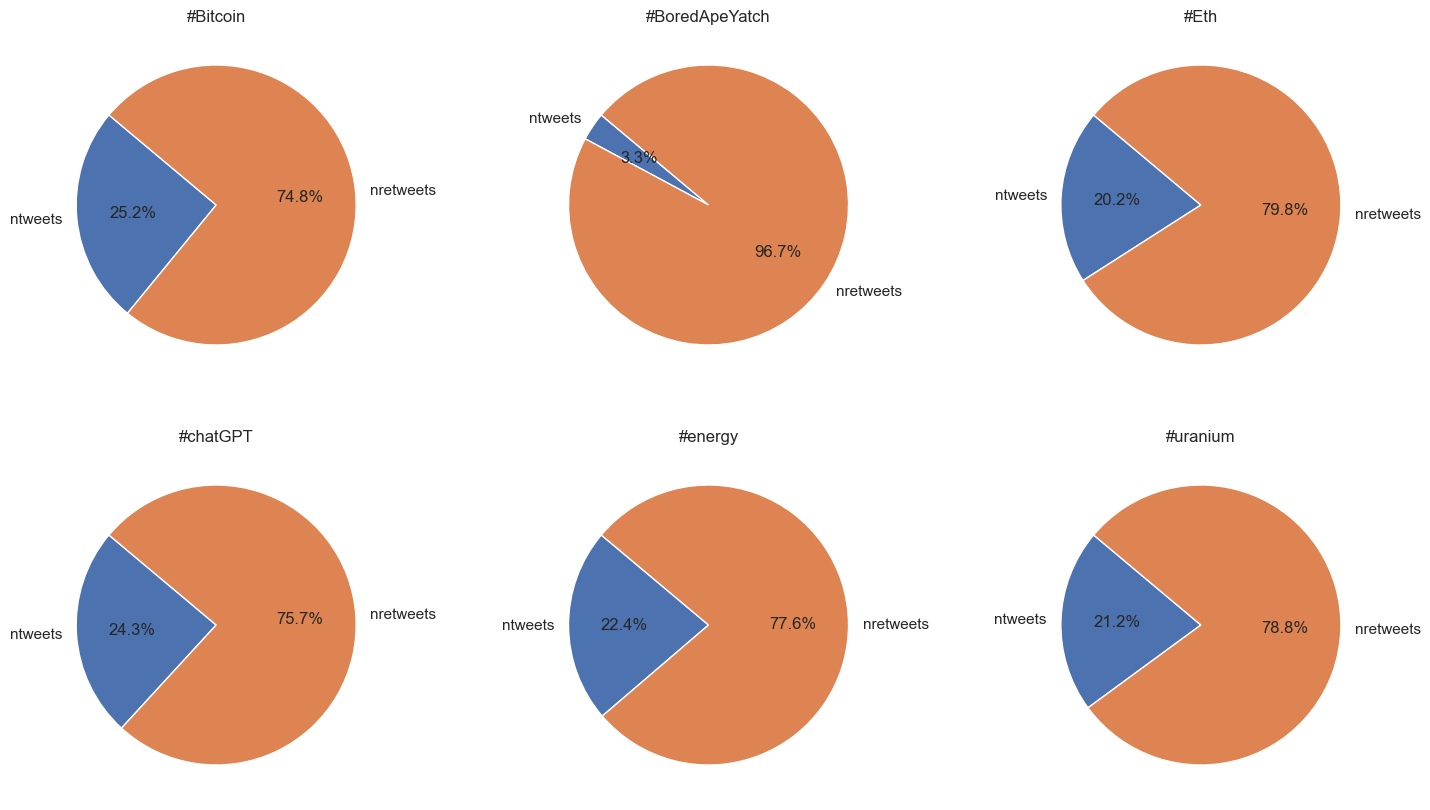

In [349]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # Adjusted for better spacing
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate over it

hashtags = TweetAgg['Hashtag'].unique()

for i, hashtag in enumerate(hashtags):
    # Ensure we don't exceed the number of subplots available
    if i >= len(axs):
        print("Not enough subplots for the number of unique hashtags.")
        break
    
    # Filter the DataFrame for the current hashtag
    df_hashtag = TweetAgg[TweetAgg['Hashtag'] == hashtag]
    
    # Plot on the ith subplot
    ax = axs[i]
    ax.pie(df_hashtag['TweetCount'], labels=df_hashtag['TweetType'], autopct='%1.1f%%', startangle=140)
    ax.set_title(hashtag)


In [248]:
Stats_comb

,Node,in_degree,out_degree,degree,closeness,betweeness,ntweets,nretweets,nfollowers,tweet_type,virality,degree_category,Hashtag,ttweets
0,BTC_Archive,0,245,245,0.000000,0.0,10.0,1.0,1205577,Tweeter,0.000203,300,#Bitcoin,11.0
1,BitcoinMagazine,0,157,157,0.000000,0.0,14.0,0.0,2824027,Tweeter,0.000056,200,#Bitcoin,14.0
2,saylor,0,130,130,0.000000,0.0,4.0,0.0,2934190,Tweeter,0.000044,150,#Bitcoin,4.0
3,GAMBproject,0,97,97,0.000000,0.0,1.0,0.0,18482,Tweeter,0.005248,100,#Bitcoin,1.0
4,rovercrc,0,81,81,0.000000,0.0,14.0,0.0,441543,Tweeter,0.000183,100,#Bitcoin,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,Momchil,1,0,1,0.017390,0.0,0.0,2.0,2165,retweeter,0.000000,5,#uranium,2.0
18175,Moorewealthal,1,0,1,0.000804,0.0,0.0,1.0,419,retweeter,0.000000,5,#uranium,1.0
18176,MoreThanMe10,11,0,11,0.019407,0.0,0.0,21.0,265,retweeter,0.000000,20,#uranium,21.0
18177,MostlypeacefulM,9,0,9,0.020378,0.0,0.0,9.0,915,retweeter,0.000000,10,#uranium,9.0


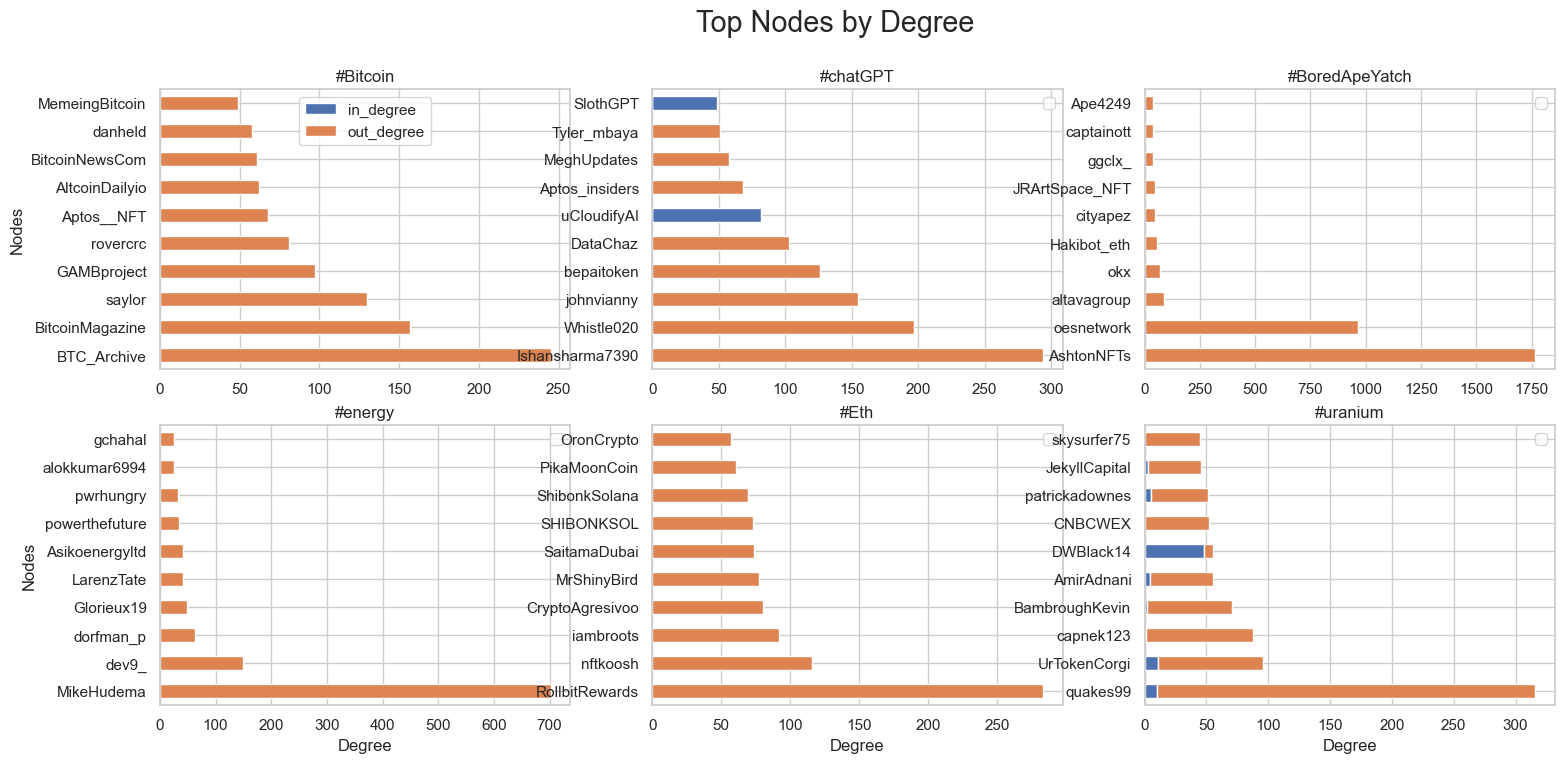

In [345]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # Adjusted for better spacing
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate over it

TopDegree = Stats_comb[['Node','Hashtag','in_degree','out_degree','degree']]
df_a = pd.DataFrame()
for i,hashtag in enumerate (TopDegree['Hashtag'].unique()):
    df = TopDegree[TopDegree['Hashtag']==hashtag]
    df = df.nlargest(10,'degree',keep='all').drop(columns=['degree']).set_index('Node')
    
    df.plot(kind='barh', stacked=True, ax=axs[i], title=hashtag)
    axs[i].legend("")
    axs[0].legend(loc='upper center')
    axs[i].set_ylabel("")
    axs[0].set_ylabel('Nodes')
    axs[3].set_ylabel('Nodes')
    axs[3].set_xlabel('Degree')
    axs[4].set_xlabel('Degree')
    axs[5].set_xlabel('Degree')
    fig.suptitle("Top Nodes by Degree", fontsize='xx-large')
    
    df_a = pd.concat([df_a,df],axis=0)

#.nlargest(10,'degree',keep='all').drop(columns=['degree']).set_index('Hashtag').plot.barh(stacked=True)

In [347]:
df_a.to_csv("TopDegree.csv")

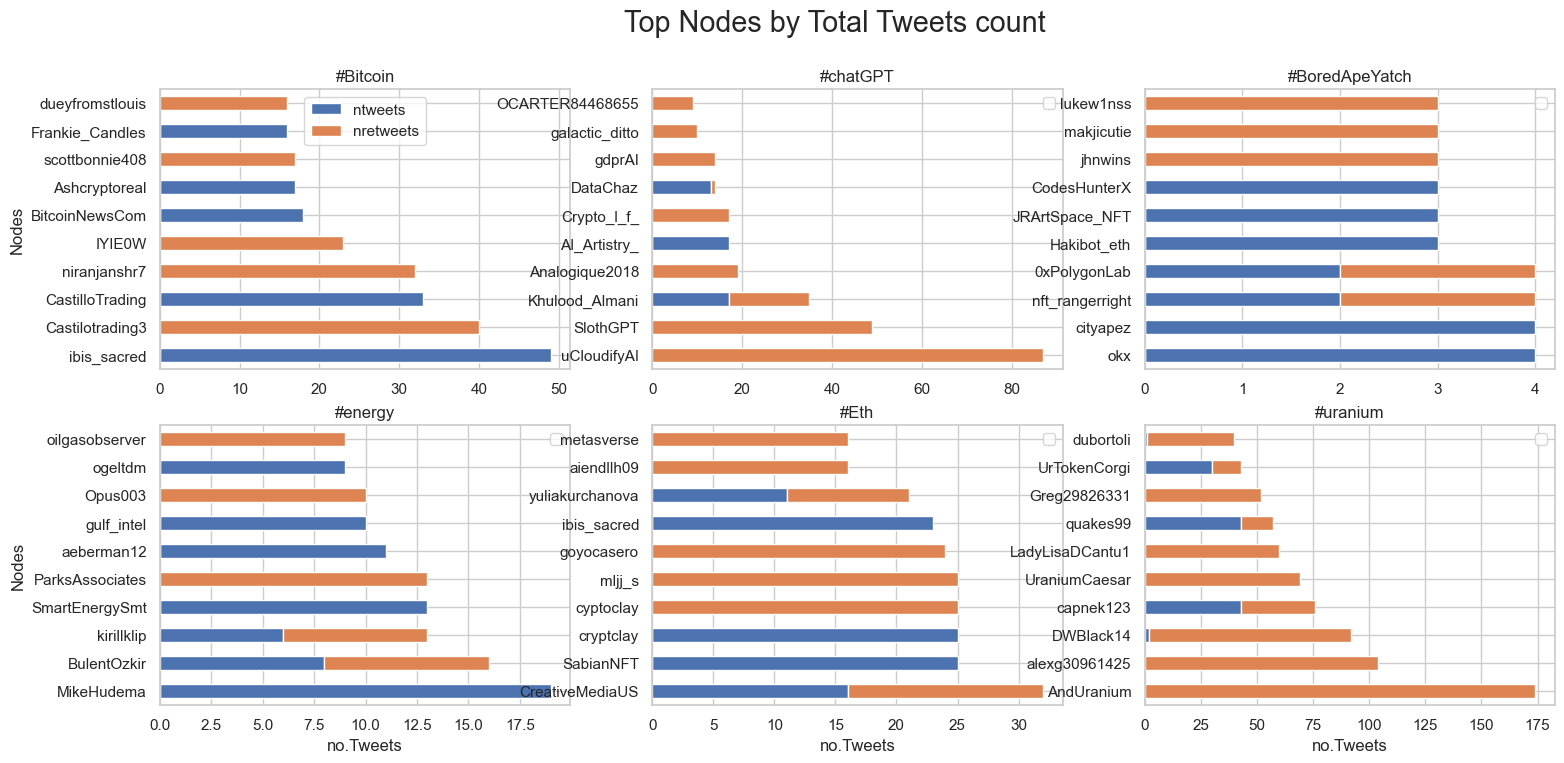

In [250]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # Adjusted for better spacing
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate over it

TopDegree = Stats_comb[['Node','Hashtag','ntweets','nretweets']]
TopDegree['ttweets'] = TopDegree['ntweets']+TopDegree['nretweets']
df_a = pd.DataFrame()
for i,hashtag in enumerate (TopDegree['Hashtag'].unique()):
    df = TopDegree[TopDegree['Hashtag']==hashtag]
    df = df.nlargest(10,'ttweets',keep='first').drop(columns=['ttweets','Hashtag']).set_index('Node')
    
    df.plot(kind='barh', stacked=True, ax=axs[i], title=hashtag)
    axs[i].set_ylabel("")
    axs[0].set_ylabel('Nodes')
    axs[3].set_ylabel('Nodes')
    axs[i].legend("")
    axs[0].legend(loc='upper center')
    axs[3].set_xlabel('no.Tweets')
    axs[4].set_xlabel('no.Tweets')
    axs[5].set_xlabel('no.Tweets')
    fig.suptitle("Top Nodes by Total Tweets count", fontsize='xx-large')
    
    df_a = pd.concat([df_a,df],axis=0)

#.nlargest(10,'degree',keep='all').drop(columns=['degree']).set_index('Hashtag').plot.barh(stacked=True)

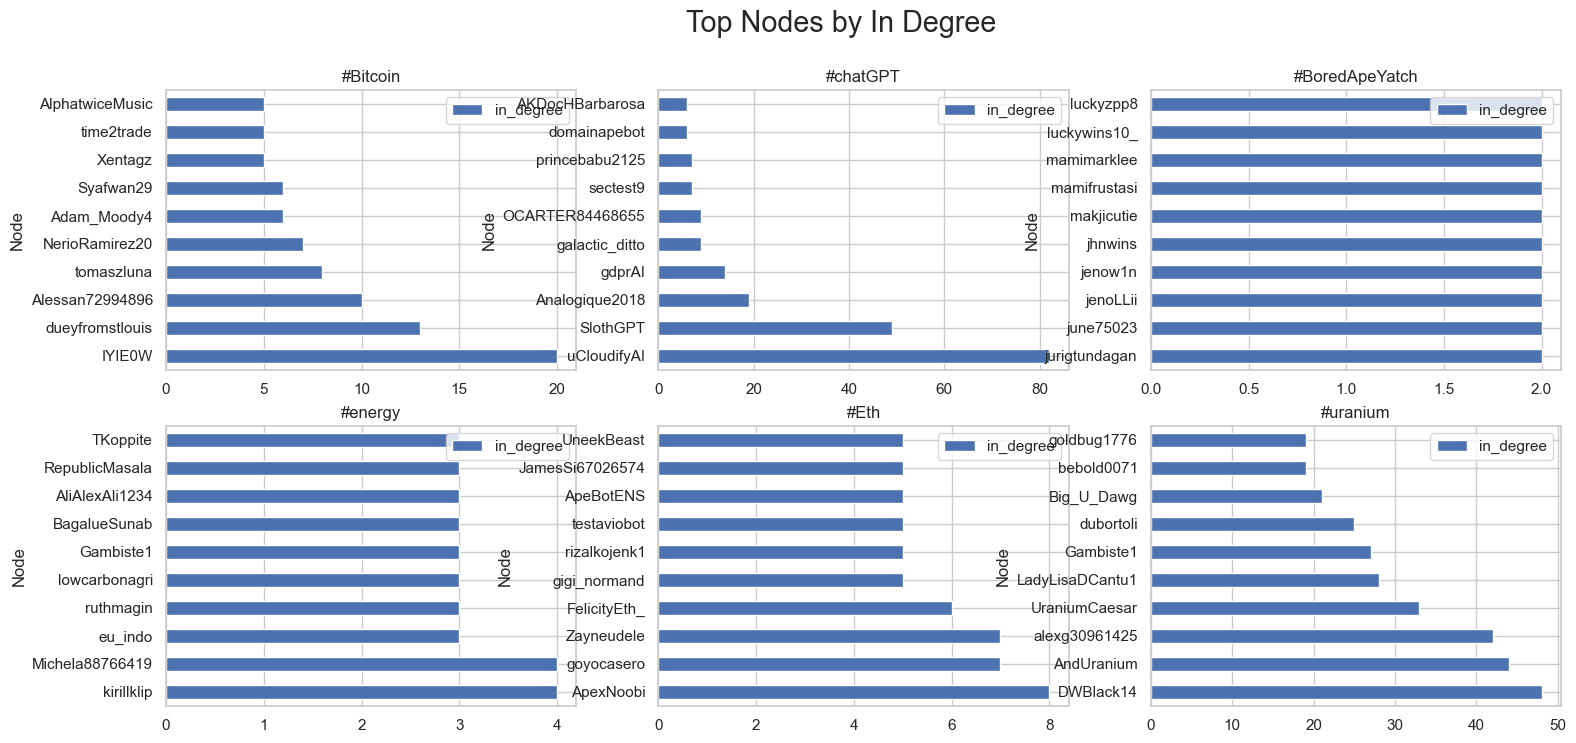

In [251]:
fig, axa = plt.subplots(2, 3, figsize=(18, 8))  # Adjusted for better spacing
axa = axa.flatten()  # Flatten the 2D array of axes to easily iterate over it

TopInDegree = Stats_comb[['Node','Hashtag','in_degree']]
df_b = pd.DataFrame()
for i,hashtag in enumerate (TopInDegree['Hashtag'].unique()):
    dfb = TopInDegree[TopInDegree['Hashtag']==hashtag]
    dfb = dfb.nlargest(10,'in_degree',keep='first').drop(columns=['Hashtag']).set_index('Node')
    
    dfb.plot(kind='barh', stacked=True, ax=axa[i], title=hashtag)
    axs[i].set_ylabel("")
    axs[0].set_ylabel('Nodes')
    axs[3].set_ylabel('Nodes')
    axs[i].legend("")
    axs[0].legend(loc='upper center')
    axs[3].set_xlabel('In Degree')
    axs[4].set_xlabel('In Degree')
    axs[5].set_xlabel('In Degree')
    fig.suptitle("Top Nodes by In Degree", fontsize='xx-large')
    
    
    df_b = pd.concat([df_a,df],axis=0)

#.nlargest(10,'degree',keep='all').drop(columns=['degree']).set_index('Hashtag').plot.barh(stacked=True)

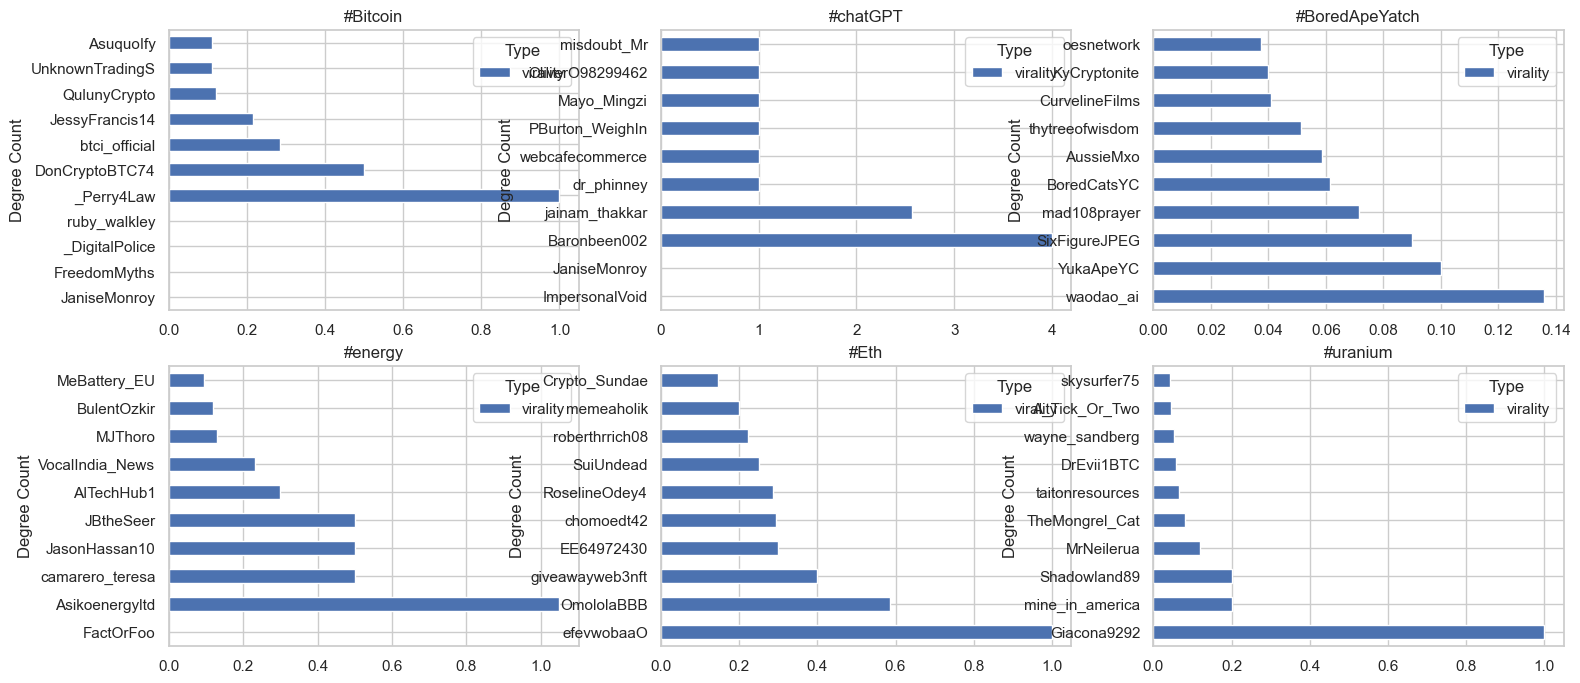

In [252]:
fig, axa = plt.subplots(2, 3, figsize=(18, 8))  # Adjusted for better spacing
axa = axa.flatten()  # Flatten the 2D array of axes to easily iterate over it

Top = Stats_comb[['Node','Hashtag','virality']]
df_b = pd.DataFrame()
for i,hashtag in enumerate (Top['Hashtag'].unique()):
    dfb = Top[Top['Hashtag']==hashtag]
    dfb = dfb.nlargest(10,'virality',keep='all').drop(columns=['Hashtag']).set_index('Node')
    
    dfb.plot(kind='barh', stacked=True, ax=axa[i], title=hashtag)
    axa[i].set_ylabel('Degree Count')
    axa[i].legend(title='Type')
    
    
    df_b = pd.concat([df_a,df],axis=0)

#.nlargest(10,'degree',keep='all').drop(columns=['degree']).set_index('Hashtag').plot.barh(stacked=True)

In [254]:
Stats_comb['ntweets'].fillna(0,inplace=True)
Stats_comb['nretweets'].fillna(0,inplace=True)

In [255]:
Stats_comb['ttweets']= Stats_comb['ntweets']+Stats_comb['nretweets']

In [256]:
Stats_comb

,Node,in_degree,out_degree,degree,closeness,betweeness,ntweets,nretweets,nfollowers,tweet_type,virality,degree_category,Hashtag,ttweets
0,BTC_Archive,0,245,245,0.000000,0.0,10.0,1.0,1205577,Tweeter,0.000203,300,#Bitcoin,11.0
1,BitcoinMagazine,0,157,157,0.000000,0.0,14.0,0.0,2824027,Tweeter,0.000056,200,#Bitcoin,14.0
2,saylor,0,130,130,0.000000,0.0,4.0,0.0,2934190,Tweeter,0.000044,150,#Bitcoin,4.0
3,GAMBproject,0,97,97,0.000000,0.0,1.0,0.0,18482,Tweeter,0.005248,100,#Bitcoin,1.0
4,rovercrc,0,81,81,0.000000,0.0,14.0,0.0,441543,Tweeter,0.000183,100,#Bitcoin,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,Momchil,1,0,1,0.017390,0.0,0.0,2.0,2165,retweeter,0.000000,5,#uranium,2.0
18175,Moorewealthal,1,0,1,0.000804,0.0,0.0,1.0,419,retweeter,0.000000,5,#uranium,1.0
18176,MoreThanMe10,11,0,11,0.019407,0.0,0.0,21.0,265,retweeter,0.000000,20,#uranium,21.0
18177,MostlypeacefulM,9,0,9,0.020378,0.0,0.0,9.0,915,retweeter,0.000000,10,#uranium,9.0


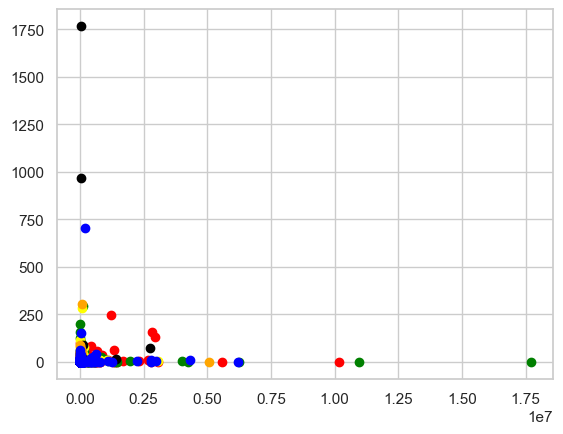

In [258]:

ax3 = plt.scatter(BTC_Stat['nfollowers'],BTC_Stat['out_degree'],c='red')
ax4 = plt.scatter(GPT_Stat['nfollowers'],GPT_Stat['out_degree'],c='green')
ax5 = plt.scatter(ETH_Stat['nfollowers'],ETH_Stat['out_degree'],c='yellow')
ax6 = plt.scatter(BRD_Stat['nfollowers'],BRD_Stat['out_degree'],c='black')
ax7 = plt.scatter(URA_Stat['nfollowers'],URA_Stat['out_degree'],c='orange')
ax8 = plt.scatter(ENG_Stat['nfollowers'],ENG_Stat['out_degree'],c='blue')

Text(0.5, 1.0, 'Node Degree Distribution')

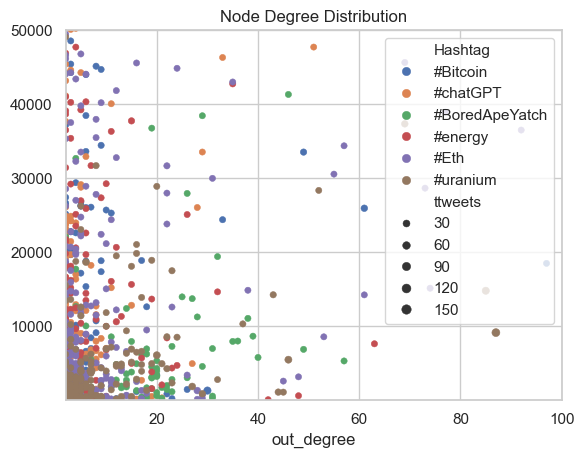

In [398]:
ax23 = sns.scatterplot(data=Stats_comb, x="out_degree", y="nfollowers", size="ttweets",sizes=(20, 50),hue='Hashtag',edgecolor=None)
#ax23.legend("")
ax23.set_xlim([2,100])
ax23.set_ylim([2,50000])
ax23.set_ylabel('')
ax23.set_title("Node Degree Distribution")

In [261]:
TopCentral = Stats_comb.copy()
central = ['degree','closeness','betweeness']
df_a = pd.DataFrame()

for hashtag in TopCentral['Hashtag'].unique():
    # Filter the DataFrame for the current hashtag
    df_hashtag = TopCentral[TopCentral['Hashtag'] == hashtag]

    for c in central:
            df = df_hashtag.nlargest(10,c,keep='all')
            df['count']=c
            df_a = pd.concat([df_a,df],axis=0)
TopCentral= df_a[~((df_a['Hashtag']=='#BoredApeYatch')&(df_a['count']=='betweeness'))]  

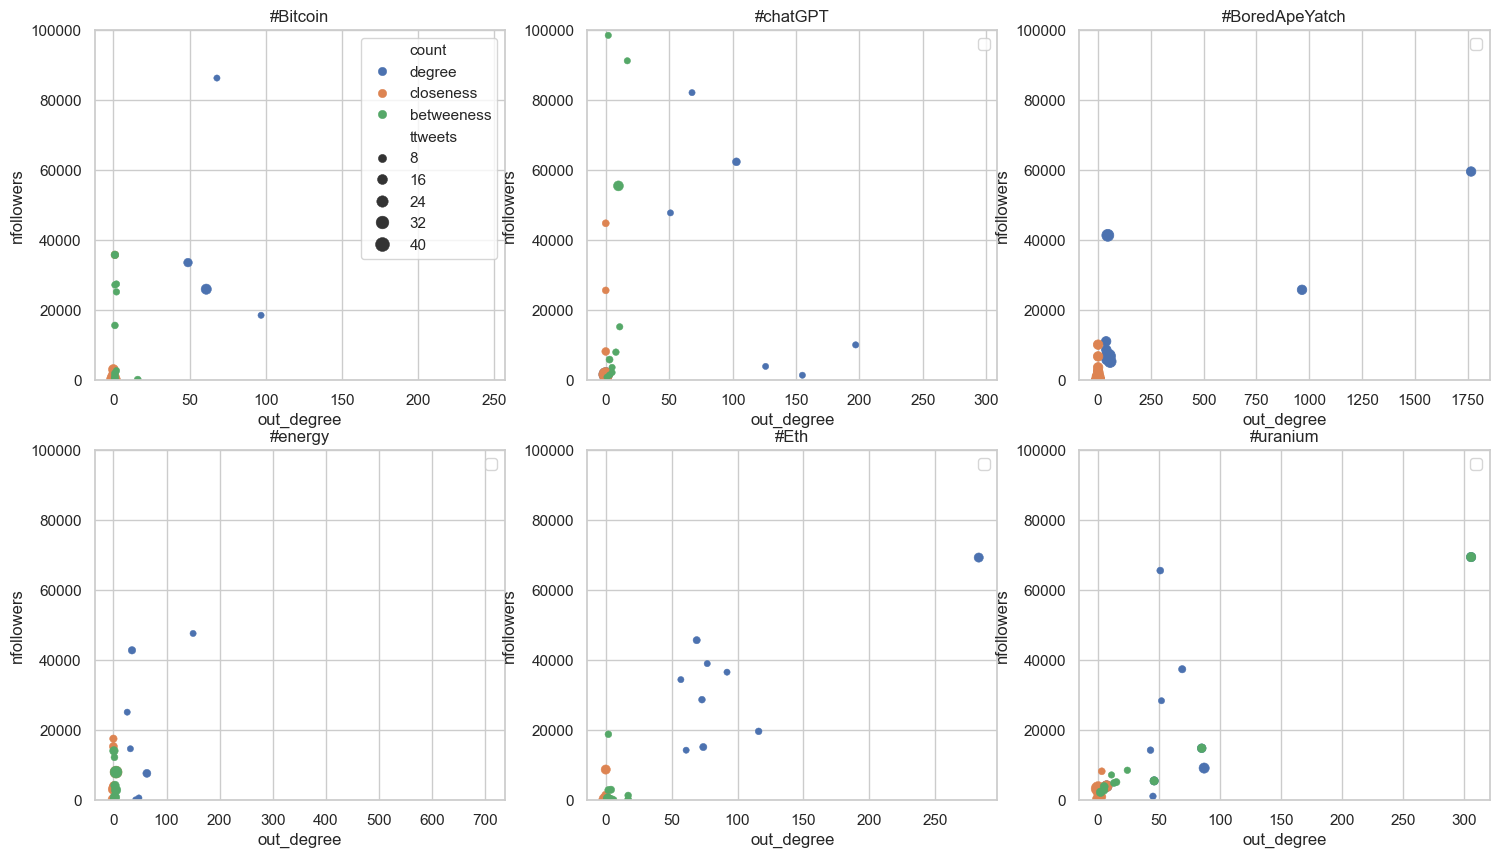

In [263]:
fig, ax =plt.subplots(2,3, figsize=(18,10))
ax = ax.flatten()
for i,hashtag in enumerate (TopCentral['Hashtag'].unique()):
    sns.scatterplot(data=TopCentral[TopCentral['Hashtag']==hashtag], x="out_degree", y="nfollowers", size="ttweets",sizes=(20, 100),hue='count',edgecolor=None, ax=ax[i])
    ax[i].legend("")
    ax[0].legend()
#     ax.set_xlim([0,200])
    ax[i].set_ylim([0,100000])
#     ax.set_ylabel('')
    ax[i].set_title(hashtag)

In [391]:
#Network statistics calculation 
Networks = [GPT,BTC,BRD,ENG,ETH,URA]
Name = ['#chatGPT', '#Bitcoin', '#BoredApeYatch','#energy','#Eth','#uranium']
metrics_list = []
for name,net in zip(Name,Networks):
    N = net.number_of_nodes()
    E = net.number_of_edges()
    d = nx.density(net)
    k = mean(dict(net.degree()).values()) #average degree
    assort = nx.degree_assortativity_coefficient(net)
    knn = nx.average_degree_connectivity(net)
    r_knn, p_value = scipy.stats.pearsonr(list(knn.keys()), list(knn.values()))
    wc_comp = len([len(a) for a in nx.weakly_connected_components(net)])
    degree_min_2 = [n for n in net.nodes() if net.degree(n) > 1]
    C = nx.average_clustering(net, degree_min_2, count_zeros=True)
    theta = 1-len(degree_min_2)/N
    C_star = (1-theta)*C
    metrics_list.append({
        'Name': name,
        'Nodes': N,
        'Edges': E,
        'Density': d,
        'Average Degree': k,
        'Assortativity': assort,
        'Average Degree Connectivity': r_knn,
        'Weakly Connected Components': wc_comp,
        'Clustering Coefficient': C,
        'Theta': theta,
        'Adjusted Clustering Coefficient': C_star
    })
Network_metrics_df = pd.DataFrame(metrics_list)

In [392]:
Network_metrics_df.set_index('Name',inplace=True)

,Nodes,Edges,Density,Average Degree,Assortativity,Average Degree Connectivity,Weakly Connected Components,Clustering Coefficient,Theta,Adjusted Clustering Coefficient
Name,,,,,,,,,,
#chatGPT,3065,2702,0.000288,1.763132,-0.177784,-0.312039,457,0.022104,0.875041,0.002762
#Bitcoin,2843,2592,0.000321,1.823426,-0.050266,0.219458,448,0.001886,0.827999,0.000324
#BoredApeYatch,4427,4419,0.000226,1.996386,0.098919,0.133659,119,0.000000,0.950983,0.000000
#energy,3105,2574,0.000267,1.657971,-0.105890,0.055391,547,0.015887,0.900805,0.001576
#Eth,3494,3320,0.000272,1.900401,-0.088704,0.116947,428,0.023871,0.819691,0.004304
#uranium,401,1408,0.008778,7.022444,-0.199349,0.055743,1,0.132616,0.000000,0.132616


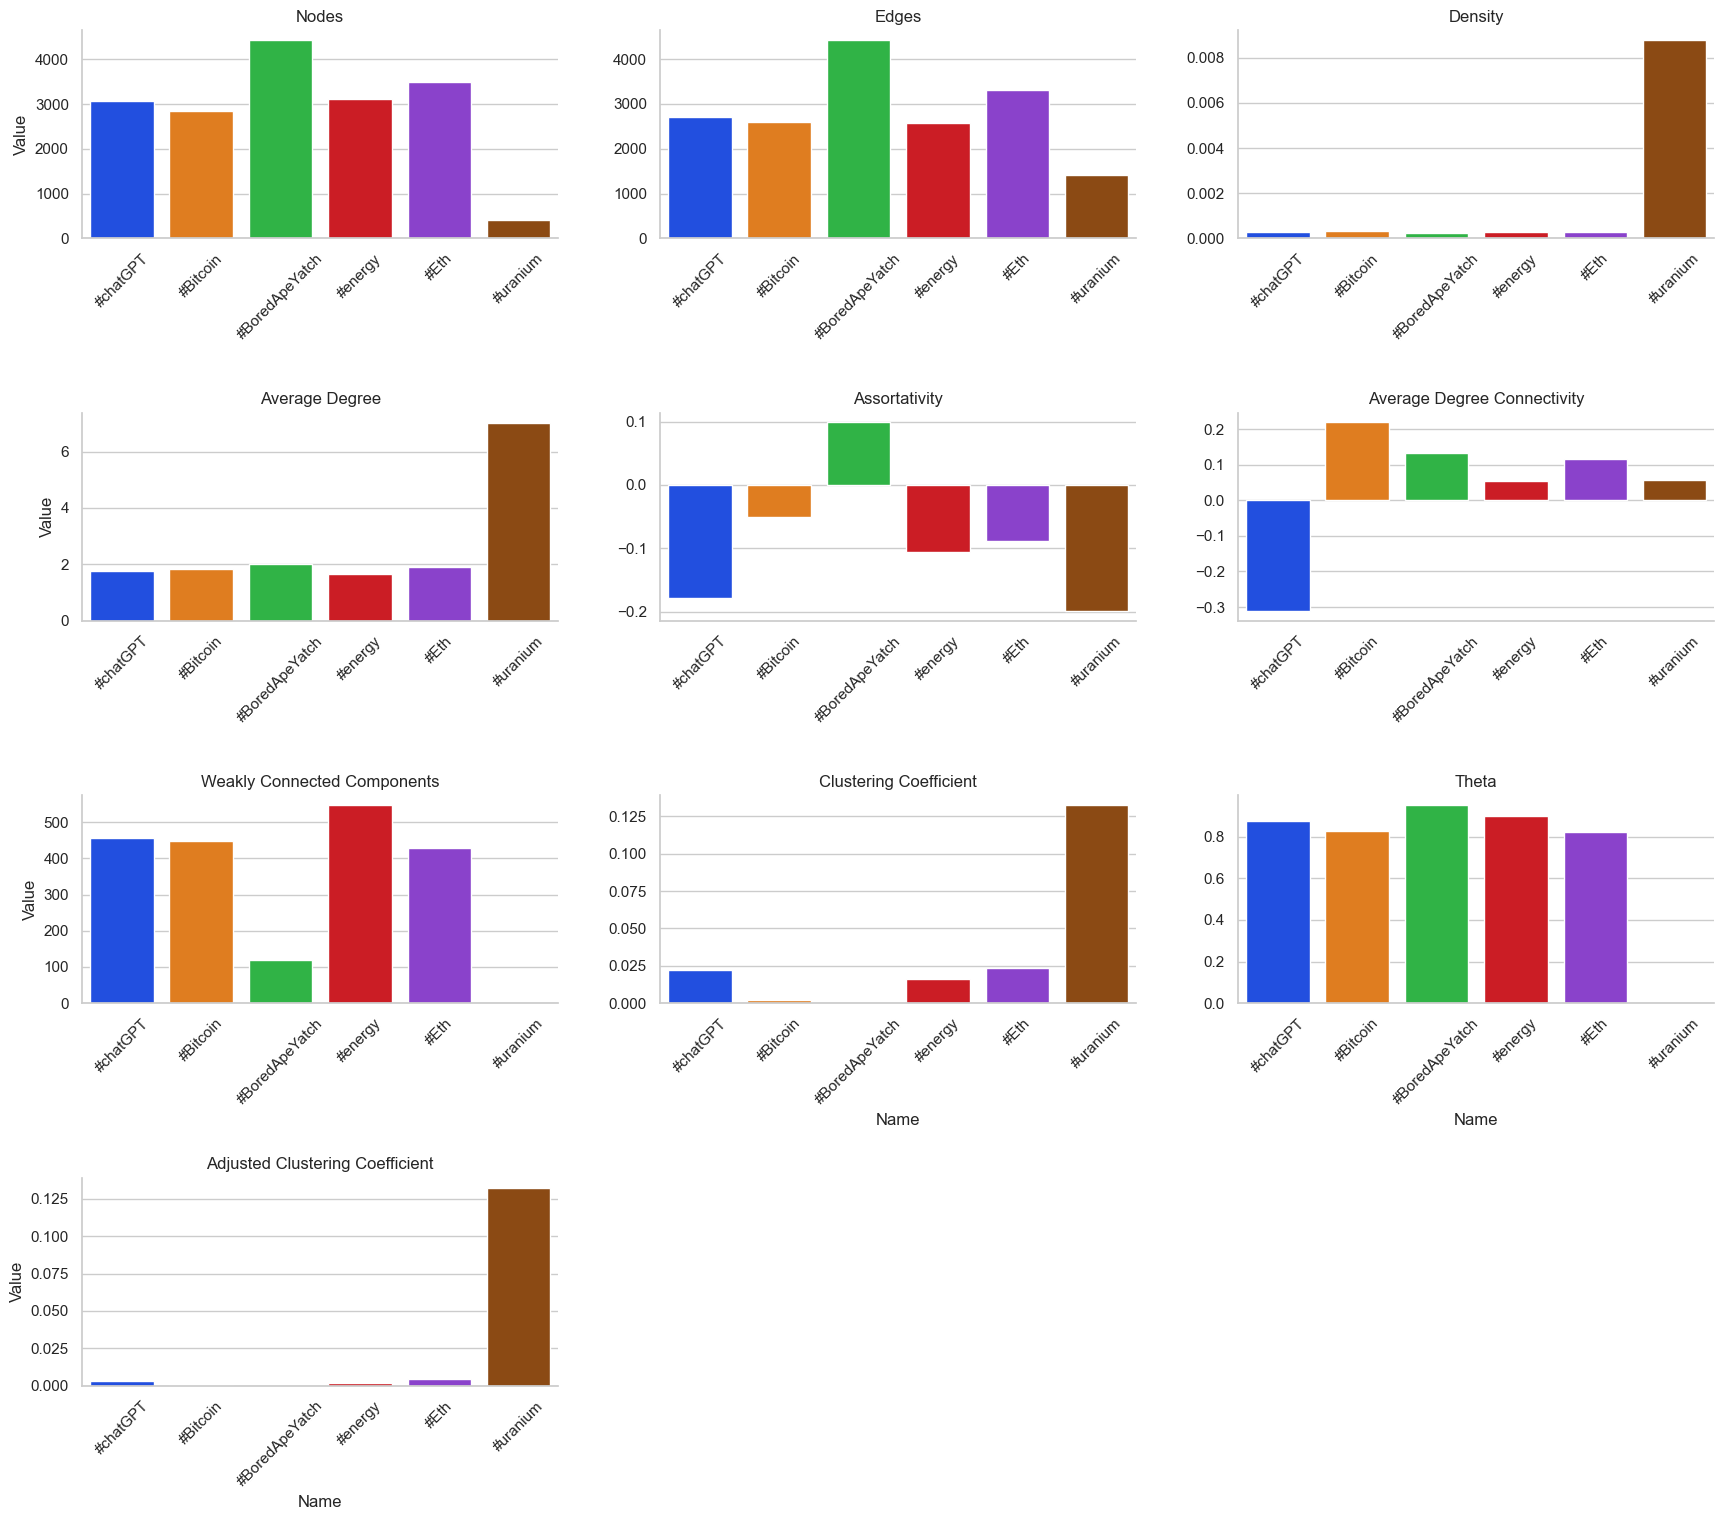

In [394]:
# Reset index so 'Name' becomes a column
Network_metrics_df.reset_index(inplace=True)

# Melt the DataFrame
df_melted = pd.melt(Network_metrics_df, id_vars=["Name"], var_name="Parameter", value_name="Value")

# Use FacetGrid to create the multi-variable comparison
g = sns.FacetGrid(df_melted, col="Parameter", col_wrap=3, sharex=False, sharey=False, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Name", y="Value", palette="bright")
g.set_xticklabels(rotation=45)
#g.bar_label(g.containers[0], fontsize=10)
g.set_titles("{col_name}")

plt.tight_layout(pad=3.0)
plt.show()


In [356]:
# Function to calculate the (complementary) cumulative probabilities -- CCDF(k)   #Copied from Topic5 code
def cumulative_prob(degree_sequence):
    degree_counts = Counter(degree_sequence)
    sorted_degrees = sorted(list(degree_counts))
    N = len(degree_sequence)
    remaining = N
    cumcount = {}
    for d in sorted_degrees:
        cumcount[d] = remaining/N
        remaining -= degree_counts[d]
    return cumcount

In [357]:
def Degree(hashtag):                  #Copied from Topic5 code
    degree_sequence = sorted([hashtag.degree(n) for n in hashtag.nodes()])
    cum_probs = cumulative_prob(degree_sequence)
    return cum_probs



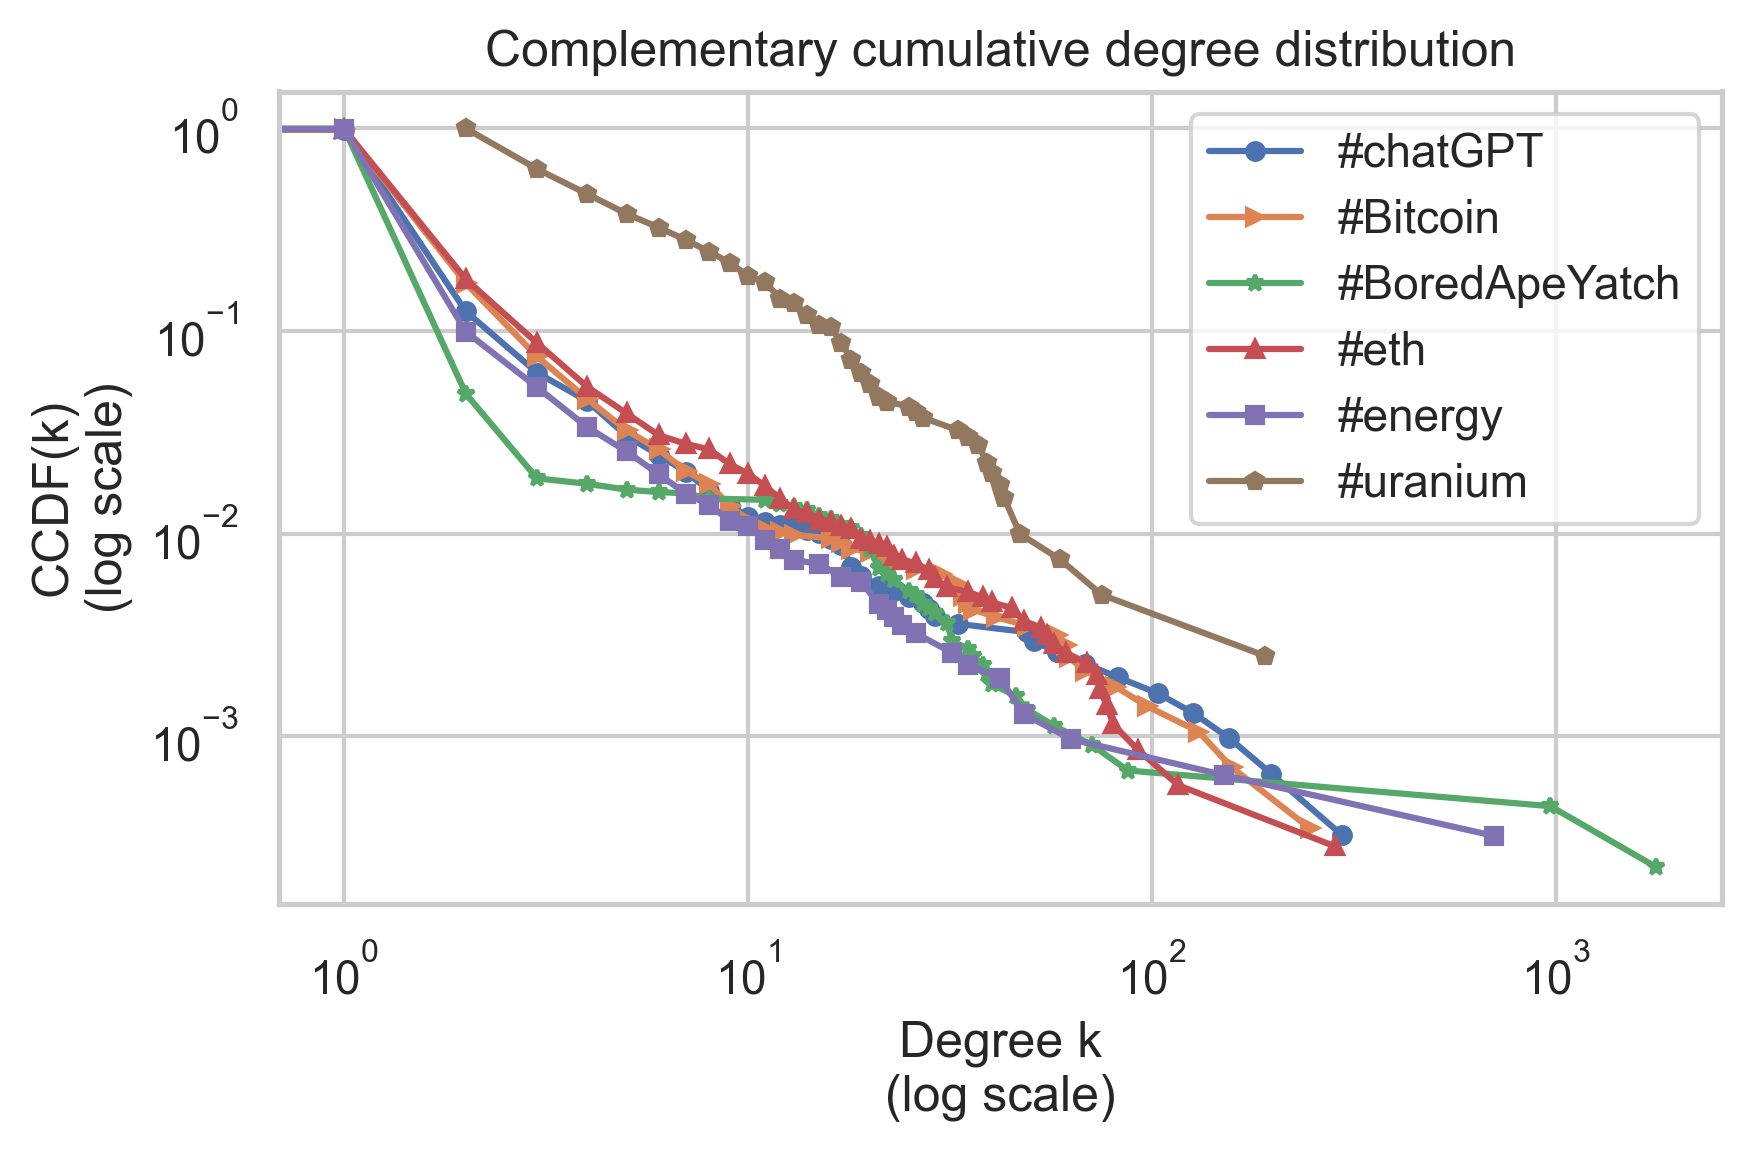

<Figure size 640x480 with 0 Axes>

In [388]:
cum_probs_GPT = Degree(GPT)     
cum_probs_BTC = Degree(BTC)
cum_probs_BRD = Degree(BRD)
cum_probs_ETH = Degree(ETH)
cum_probs_ENG = Degree(ENG)
cum_probs_URA = Degree(URA)

# Plot the Cumulative Degree Distribution
plt.figure(figsize=(6,4), dpi=300, tight_layout=True)
plt.title('Complementary cumulative degree distribution')
plt.xlabel('Degree k\n(log scale)')
plt.ylabel('CCDF(k)\n(log scale)')
plt.xscale('log')
plt.yscale('log')
plt.plot(cum_probs_GPT.keys(), cum_probs_GPT.values(), marker='o',markersize = 4,label = '#chatGPT')
plt.plot(cum_probs_BTC.keys(), cum_probs_BTC.values(), marker='>',markersize = 4,label = '#Bitcoin')
plt.plot(cum_probs_BRD.keys(), cum_probs_BRD.values(), marker='*',markersize = 4,label = '#BoredApeYatch')
plt.plot(cum_probs_ETH.keys(), cum_probs_ETH.values(), marker='^',markersize = 4,label = '#eth')
plt.plot(cum_probs_ENG.keys(), cum_probs_ENG.values(), marker='s',markersize = 4,label = '#energy')
plt.plot(cum_probs_URA.keys(), cum_probs_URA.values(), marker='p',markersize = 4,label = '#uranium')
plt.legend()
plt.show()
plt.savefig('G_cum_degree_hist.png')

In [280]:
import re

def remove_URL(text):
    """Remove URLs from a text string."""
    return re.sub(r"http\S+", "", text)

In [293]:
texta = [tweet['full_text'] for tweet in chatGPT]

In [296]:
texta
text = ' '.join(texta)

In [304]:
stopwords = set(STOPWORDS)
stopwords.update(["ChatGPT","going","way","will","know"])

In [321]:
def remove_URL(text):
    """Remove URLs from a text string."""
    return re.sub(r"http\S+", "", text)
    
def wordcloud (hashtag, Name, stopword=None):
    texta = [tweet['full_text'] for tweet in hashtag]
    text = ' '.join(texta)
    stopwords = set(STOPWORDS)
    stopwords.update(["ChatGPT","going","way","will","know"])
    if stopword:
        stopwords.update(stopword)
    wordcloud = WordCloud(stopwords=stopwords,background_color = 'white').generate(remove_URL(text))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Name)
    plt.show()

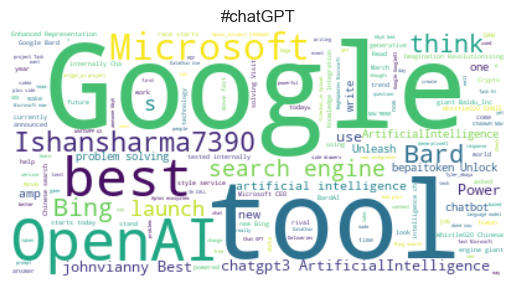

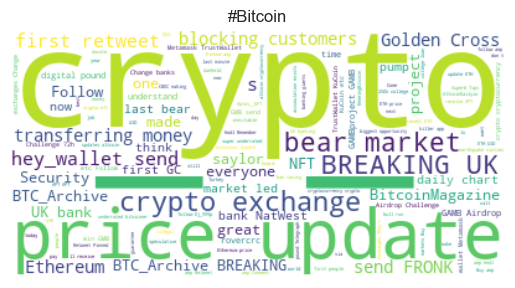

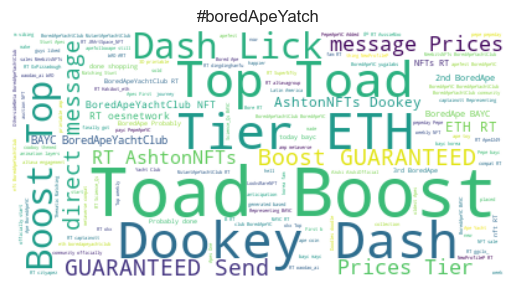

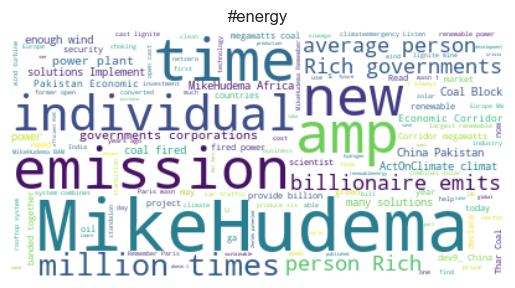

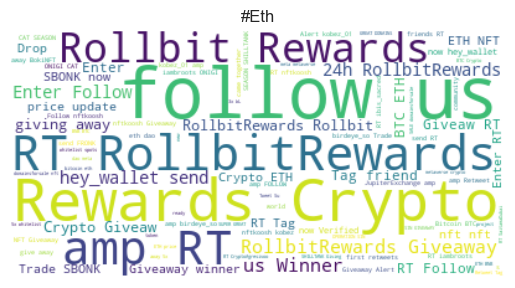

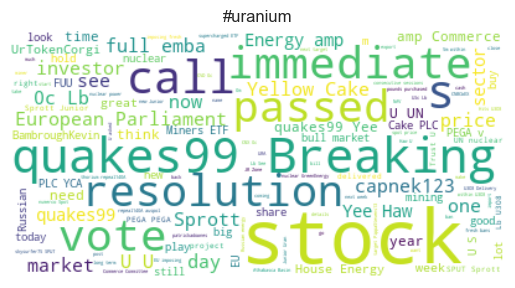

In [399]:
wordcloud(chatGPT,"#chatGPT",["AI",'RT','need'])
wordcloud(bitcoin,"#Bitcoin",['Bitcoin','BTC','RT'])
wordcloud(boredApeYachtClub,"#boredApeYatch")
wordcloud(energy,"#energy",['energy','RT'])
wordcloud(eth,"#Eth")
wordcloud(uranium,"#uranium",['uranium','RT'])

# BTC_Stat = NodeStats(BTC,bitcoin)
# GPT_Stat = NodeStats(GPT,chatGPT)
# BRD_Stat = NodeStats(BRD,boredApeYachtClub)
# ENG_Stat = NodeStats(ENG,energy)
# ETH_Stat = NodeStats(ETH,eth)
# URA_Stat = NodeStats(URA,uranium)

NameError: name 'df_network_stats' is not defined

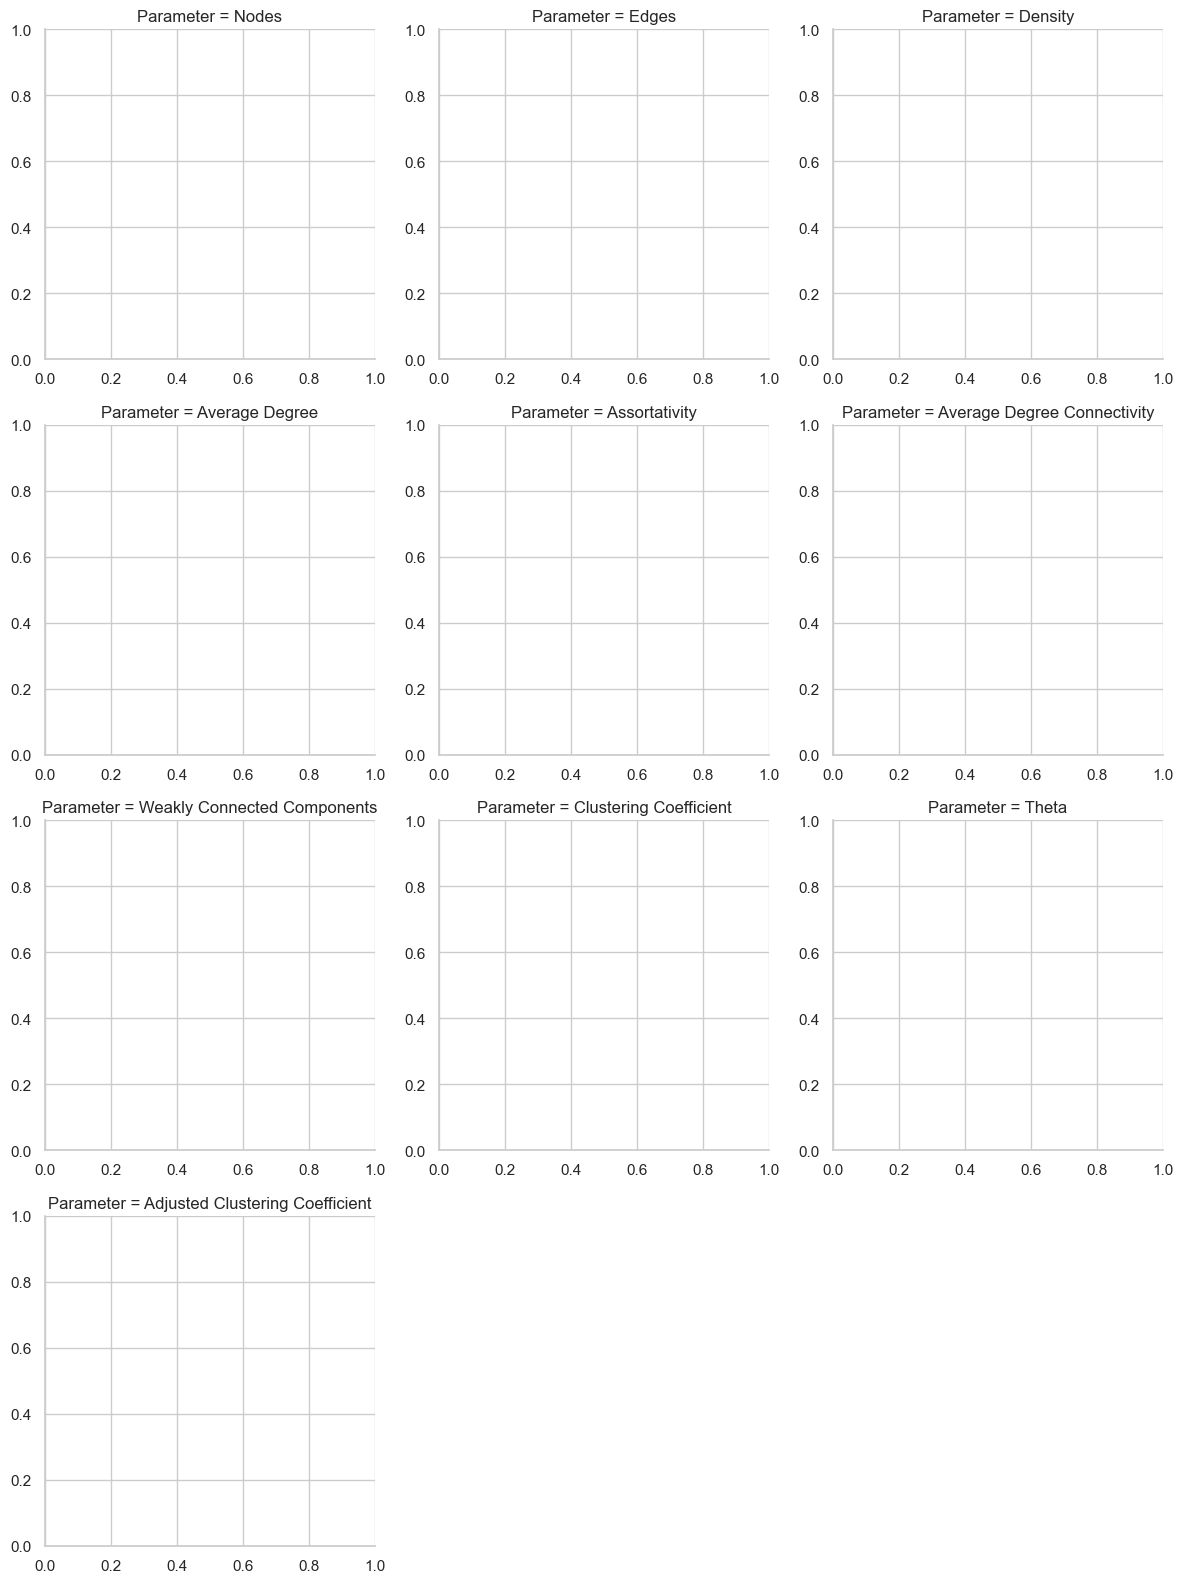

In [299]:
# Assuming df_network_stats is already created as per your description

# Melt the DataFrame to have variable names as one of the columns and values as another
df_melted = pd.melt(Network_metrics_df, id_vars=["Name"], var_name="Parameter", value_name="Value")

# Now, let's use Seaborn's FacetGrid to create multi-variable comparison
g = sns.FacetGrid(df_melted, col="Parameter", col_wrap=3, sharex=False, sharey=False, height=4)
g.map(sns.barplot, "Name", "Value", palette="viridis", order=df_network_stats['Name'])

# Rotate x-axis labels for readability and adjust the layout
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()


### Volume of Data

In [80]:
print("#bitcoin: ", os.path.getsize('Retweet-JSON/#Bitcoin.json')/1000 / len(bitcoin), 'MB per tweet')
print("#chatgpt: ", os.path.getsize('Retweet-JSON/#chatgpt.json')/1000 / len(chatGPT), 'MB per tweet')
print("#energy: ", os.path.getsize('Retweet-JSON/#energy.json')/1000 / len(energy), 'MB per tweet')
print("#Eth: ", os.path.getsize('Retweet-JSON/#Eth.json')/1000 / len(eth), 'MB per tweet')
print("#uranium: ", os.path.getsize('Retweet-JSON/#uranium.json')/1000 / len(uranium), 'MB per tweet')

#bitcoin:  5.813622840119166 MB per tweet
#chatgpt:  6.4814694 MB per tweet
#energy:  6.265687000000001 MB per tweet
#Eth:  6.821722855428915 MB per tweet
#uranium:  6.2488214 MB per tweet


### Velocity of Data

In [1]:
def dataVs(hashtag):
    daten = [tweet['created_at'] for tweet in hashtag]
    name = hashtag[0]['entities']['hashtags'][0]['text']
    # Convert string to datetime objects
    datetime_o = [datetime.strptime(date_s, '%a %b %d %H:%M:%S %z %Y') for date_s in daten]
    duration = max(datetime_o)-min(datetime_o)
    rate = duration / len(hashtag)
    print(name,"\t:\t ",rate ,"; collection duration:\t",duration, ";\t", "Date: \t", datetime_o[0].date())


In [2]:
dataVs(chatGPT)
dataVs(bitcoin)
dataVs(boredApeYachtClub)
dataVs(energy)
dataVs(eth)
dataVs(uranium)

NameError: name 'chatGPT' is not defined

In [122]:
chatGPT[0]['entities']['hashtags'][0]['text']

'ChatGPT'

In [101]:
daten = [tweet['created_at'] for tweet in chatGPT]

In [103]:
datetime_o = [datetime.strptime(date_s, '%a %b %d %H:%M:%S %z %Y') for date_s in daten]

In [109]:
print(datetime_o[0].date())

2023-02-06
